In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

# Simple box object detection


![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_label.PNG?raw=1)

## find out regression function, fit hand-craft features with object center x y and object width height

## For example, input this image, output return $(\ center_{y} \ , \ center_{x} \ , \ box_{height} \ , \ box_{width}) = ( \ 4.5 \ , \ 3 \ , \ 6 \ , \ 5) $

## !pip install opencv-python
### # if necessary

In [3]:
import cv2

### set plot size

In [4]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [5]:
plt.rcParams['figure.figsize'] = [8, 8]

## image with rectangle

### frame with random white
### crop with selected mask


(9, 12)


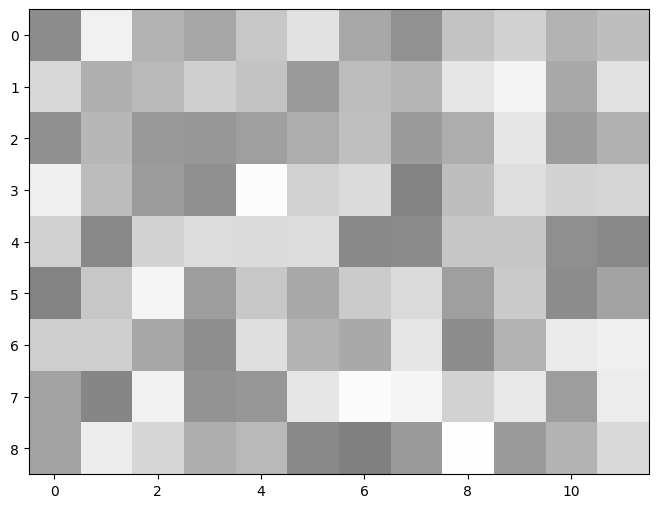

In [6]:
# small frame example
width, height = 12, 9
frame_full = np.random.rand(height, width) * 128 + 128
frame_full = frame_full.astype(np.uint8)

print(frame_full.shape)

plt.imshow(frame_full, cmap='gray', vmin=0, vmax=255)
plt.show()

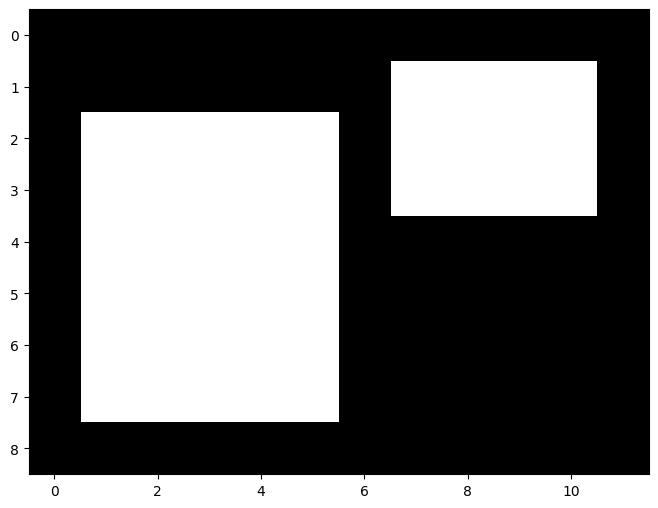

In [7]:
mask = np.zeros([height, width], dtype="uint8")
cv2.rectangle(mask, (1, 2), (5, 7), 255, -1)
cv2.rectangle(mask, (7, 1), (10, 3), 255, -1)

plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.show()

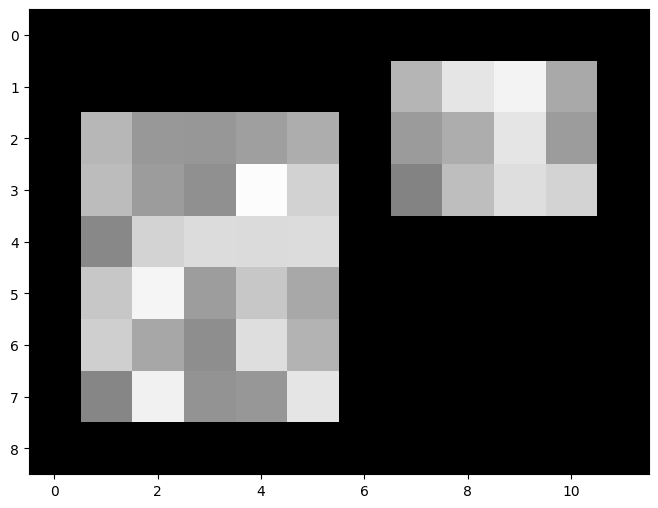

In [8]:
frame_2d = cv2.bitwise_and(frame_full, frame_full, mask=mask)

plt.imshow(frame_2d, cmap='gray', vmin=0, vmax=255)
plt.show()

# Introduction of hand-craft features for box detection
### One-stage detection

Here we'll show how to define hand-craft features for one-stage object detection, demonstrating a way to do regression on object detection.
With a proper feature engineering on simple objects, we'll able to find a regression function between features and target location(box center, height, width)

<font size="5">$F_{reg}(features) = (classProb \ ,  \ center_{y} \ , \ center_{x} \ , \ box_{height} \ , \ box_{width}) $</font>



### Start from simple example
Here's a box in frame: 

![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_base.PNG?raw=1)

<font size="5">$Label: (\ center_{y} \ , \ center_{x} \ , \ box_{height} \ , \ box_{width}) = ( \ 4.5 \ , \ 3 \ , \ 6 \ , \ 5) $</font>

Without loss of generality, we observe row to show how features defined(similarly as column)
Prepare an empty array, same size as image frame.

For each pixel in box, we record the row position of the pixel, for example if a pixel at (2, 1) in box, we record number 2. Pixels outside box record as zero. 

Define the feature as first feature, named as "loc" (location)

<font size="10"><center>loc</center></font>

![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_row_axis.PNG?raw=1)

For second feature, prepare an empty array, same size as image frame.

Observe from top to down, pixel with least row ith as 1, second least row ith as 2, etc

Define the feature named as "cumul" (cumulative)

<font size="10"><center>cumul</center></font>

![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_row_cumul.PNG?raw=1)


For third feature, prepare an empty array, same size as image frame.

Observe from down to top, pixel with largest row ith as 1, second largest row ith as 2, etc

Define the feature named as "inv_cumul" (inverse cumulative)

<font size="10"><center>inv_cumul</center></font>



![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_row_inv_cumul.PNG?raw=1)

## Further compute these features

To get center y, get median/mean value of rows:

<font size="10"><center>$final_{loc} \ = \ loc + \frac{inv\_cumul - cumul}{2}$</center></font>

![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_row_final_loc.PNG?raw=1)

Average of positive values exactly the same as label $center_{y}: 4.5$


To get obj height:

<font size="10"><center>$final_{cumul} \ = \  cumul + inv\_cumul $</center></font>

![](https://github.com/KuoYuChang/Colab_Ipynb/blob/main/video_course/assests/frame_row_final_cumul.PNG?raw=1)

Compute average of positive vaules, we got 7, close to label $box_{height}: 6$

So we have row features: $4.5, 7$, similarly, we'll get column feature: $3, 6$ 

Hence we have the feature: $(4.5, 3, 7, 6)$

## set regression layer
### to find relation between feature and label

<font size="5">$Label: (\ center_{y} \ , \ center_{x} \ , \ box_{height} \ , \ box_{width}) $</font>

<font size="5">$Feature: (\ 4.5 \ , 3 \ , \ 7 \ , \ 6) -> \ Label: ( \ 4.5 \ , \ 3 \ , \ 6 \ , \ 5) $</font>

Pretty close to ground truth, only some bias.

### feature about obj type classification

Here we simply ___take average___ of colors in cell, higher more likely to be object in cell

feature transformations to get final features, on method ___img2feature___

## model class, hand-craft features, simple regression

In [9]:
class BoxDetect(nn.Module):
    def __init__(self, num_cell=5):
        super(BoxDetect, self).__init__()

        self.num_feature = 5
        # input feature will be like [batch, 5, cell, cell]
        self.reg = nn.Conv2d(in_channels=self.num_feature, out_channels=self.num_feature, kernel_size=1, padding=0, groups=self.num_feature)
        self.cls_acti = nn.Sigmoid()

        self.num_cell = num_cell

        # manually set weight
        ones_arr = np.ones(5)
        ones_arr = ones_arr.reshape((5, 1, 1, 1))
        reg_weight = torch.from_numpy(ones_arr)
        self.reg.weight = torch.nn.Parameter(reg_weight.float())
        
        # manually set bias
        cls_bias = torch.tensor([-0.25])
        center_bias = torch.tensor([0, 0])
        box_bias = torch.tensor([-2, -2])
        
        full_bias = torch.cat( (cls_bias, center_bias, box_bias), 0)
        self.reg.bias = torch.nn.Parameter(full_bias.float())

        # or prepare loss and optimizer

        print("******************************************************")
        print()
        print("   Type of input image is numpy arr here.")
        print()
        print("   Remember shape of input image is like [b, c, h, w]")
        print()
        print("******************************************************")
    
    # methods to get hand-craft features
    
    # pixel-wise bool, obj or background
    def obj_pix(self, frame, white_thres=127):
        bool_frame = frame > white_thres
        return bool_frame
    # location, positive, obj_bool*xy as expected value
    def location(self, frame, bool_frame):
    
        b, c, h, w = frame.shape
    
        h_temp = np.arange(h)
        h_temp = h_temp.reshape((h, 1))
        h_loc = np.repeat(h_temp, w, axis=1)
        h_loc = np.expand_dims(h_loc, axis=(0, 1))
    
        w_temp = np.arange(w)
        w_temp = w_temp.reshape((1, w))
        w_loc = np.repeat(w_temp, h, axis=0)
        w_loc = np.expand_dims(w_loc, axis=(0, 1))
    
        h_loc = bool_frame * h_loc
        w_loc = bool_frame * w_loc
    
        loc = np.zeros([2, b, c, h, w])
        loc[0] = h_loc
        loc[1] = w_loc
    
        print("location: ")
        print(loc)
        
    
        return loc
    
    def loc_reg(self, loc, cumul_arr, inv_cumul_arr):
    
        _, b, c, h, w = loc.shape
        
        h_loc = loc[0] + ( inv_cumul_arr[0] - cumul_arr[0] ) / 2
    
        w_loc = loc[1] + ( inv_cumul_arr[1] - cumul_arr[1] ) / 2
    
        print("h loc: ")
        print(h_loc)
        print("w loc: ")
        print(w_loc)
    
        final_loc = np.zeros([2, b, c, h, w])
        final_loc[0] = h_loc
        final_loc[1] = w_loc
    
        return final_loc
    
    
    
    # cumulative
    def cumul(self, frame, bool_frame):
        b, c, h, w = frame.shape
    
        cumul_arr = np.zeros([2, b, c, h, w])

        for bi in range(b):
            for ci in range(c):
                for i in range(h):
                    for j in range(w):
                        if bool_frame[bi, ci, i, j]:
            
                            # cumulative add along h
                            if i > 0:
                                cumul_arr[0, bi, ci, i, j] = cumul_arr[0, bi, ci, i-1, j] + 1
                            else:
                                cumul_arr[0, bi, ci, i, j] = 1
            
                            # cumulative add along w
                            if j > 0:
                                cumul_arr[1, bi, ci, i, j] = cumul_arr[1, bi, ci, i, j-1] + 1
                            else:
                                cumul_arr[1, bi, ci, i, j] = 1
    
        print("cumulative: ")
        print(cumul_arr)
        
        return cumul_arr
        
    # inv-cumulative
    def inv_cumul(self, frame, bool_frame):
        b, c, h, w = frame.shape
    
        inv_cumul_arr = np.zeros([2, b, c, h, w])


        
        for bi in range(b):
            for ci in range(c):
                for i in range(h):
                    inv_i = h - i - 1
                    for j in range(w):
                        inv_j = w - j - 1
                        
                        if bool_frame[bi, ci, inv_i, inv_j]:
            
                            # cumulative add along h
                            if inv_i < h-1:
                                inv_cumul_arr[0, bi, ci, inv_i, inv_j] = inv_cumul_arr[0, bi, ci, inv_i+1, inv_j] + 1
                            else:
                                inv_cumul_arr[0, bi, ci, inv_i, inv_j] = 1
            
                            # cumulative add along w
                            if inv_j < w-1:
                                inv_cumul_arr[1, bi, ci, inv_i, inv_j] = inv_cumul_arr[1, bi, ci, inv_i, inv_j+1] + 1
                            else:
                                inv_cumul_arr[1, bi, ci, inv_i, inv_j] = 1
    
        print("inverse cumulative: ")
        print(inv_cumul_arr)
        
        return inv_cumul_arr
    
    def h_w_reg(self, cumul_arr, inv_cumul_arr):
    
        final_cumul = cumul_arr + inv_cumul_arr
        print("final_cumul: ")
        print(final_cumul)

        return final_cumul


    # only one object available in Cell
    def get_box_fea(self, loc, cumul):
        
        # get positive value
        pos_loc_cnt = (loc > 0).astype(np.uint8)
        pos_cumul_cnt = (cumul > 0).astype(np.uint8)
    
        # sum value / sum count
        loc_sum = np.sum(loc, axis=(1, 2, 3, 4))
        cumul_sum = np.sum(cumul, axis=(1, 2, 3, 4))

        loc_cnt_num = np.sum(pos_loc_cnt, axis=(1, 2, 3, 4))
        cumul_cnt_num = np.sum(pos_cumul_cnt, axis=(1, 2, 3, 4))

        # manually compute, to handle zero division
        center_xy = np.zeros(2)
        box_hw = np.zeros(2)

        for i in range(2):
            if loc_cnt_num[i] > 0:
                center_xy[i] = loc_sum[i] / loc_cnt_num[i]
            else:
                center_xy[i] = 0

            if cumul_cnt_num[i] > 0:
                box_hw[i] = cumul_sum[i] / cumul_cnt_num[i]
            else:
                box_hw[i] = 0

        return np.concatenate((center_xy, box_hw))
        

    def img2feature(self, frame, white_thres=127):

        ##################################################################
        # whole frame preprocessing
        bool_frame = self.obj_pix(frame, white_thres=white_thres)
        
        loc = self.location(frame, bool_frame)
        cumul_arr = self.cumul(frame, bool_frame)
        inv_cumul_arr = self.inv_cumul(frame, bool_frame)

        ##################################################################
        # get final features
        final_loc = self.loc_reg(loc, cumul_arr, inv_cumul_arr)
        final_cumul = self.h_w_reg(cumul_arr, inv_cumul_arr)


        ##################################################################
        # now xy location, cumulative, inverse-cumulative be prepared

        # cell-wise operation
        # take average
        b, c, h, w = frame.shape

        obj_feature = np.zeros([b, self.num_feature, self.num_cell, self.num_cell])

        
        cell_h = int( h / self.num_cell )
        cell_w = int( w / self.num_cell )
        
        for i in range(self.num_cell):
            h_start = i * cell_h
            h_end = 0
            if i >= self.num_cell-1:
                h_end = h
            else:
                h_end = (i+1)*cell_h
            
            for j in range(self.num_cell):
                
                w_start = j * cell_w
                w_end = 0

                if j >= self.num_cell-1:
                    w_end = w
                else:
                    w_end = (j+1)*cell_w

                # classification, if rectangle or not
                frame_cell = frame[:, :, h_start:h_end, w_start:w_end]
                mean_color = np.mean(frame_cell, axis=(1, 2, 3))
                mean_color = mean_color / 255.
    
                # regression, box
                loc_cell = final_loc[:, :, :, h_start:h_end, w_start:w_end]
                cumul_cell = final_cumul[:, :, :, h_start:h_end, w_start:w_end]

    
                box_feature = self.get_box_fea(loc_cell, cumul_cell)
    
                obj_feature[:, 0, i, j] = mean_color
                obj_feature[:, 1:, i, j] = box_feature

        print("color feature for classification: ")
        print(obj_feature[:, 0, :, :])
        
        return obj_feature

    def forward(self, frame):

        reg_fea = self.img2feature(frame)

        reg_tensor = torch.from_numpy(reg_fea).float()
        
        result = self.reg(reg_tensor)
        cls = self.cls_acti(result[:, 0, :, :])

        # consider shape again?
        result[:, 0, :, :] = cls

        return result

In [10]:
# regression, estimated center, h, w to real ones

# classification, ratio of color, eg threshold 127

In [11]:
boxDetect = BoxDetect(num_cell=7)

******************************************************

   Type of input image is numpy arr here.

   Remember shape of input image is like [b, c, h, w]

******************************************************


#### prepare input frame for torch

In [12]:
frame = np.expand_dims(frame_2d, axis=(0, 1) )
frame

array([[[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0, 181, 229, 244, 169,   0],
         [  0, 183, 152, 151, 159, 173,   0, 155, 173, 229, 156,   0],
         [  0, 188, 156, 144, 252, 210,   0, 132, 190, 222, 211,   0],
         [  0, 136, 212, 220, 219, 220,   0,   0,   0,   0,   0,   0],
         [  0, 199, 245, 157, 199, 168,   0,   0,   0,   0,   0,   0],
         [  0, 207, 167, 142, 222, 179,   0,   0,   0,   0,   0,   0],
         [  0, 134, 241, 148, 151, 229,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]]],
      dtype=uint8)

## observe feature and ground truth of center x, y, height, width of boxes

### center x, y, same as ground truth

### height, width, intercept/bias -2 to get ground truth

In [13]:
## explore depth-wise cnn

boxDetect.reg.weight, boxDetect.reg.bias

(Parameter containing:
 tensor([[[[1.]]],
 
 
         [[[1.]]],
 
 
         [[[1.]]],
 
 
         [[[1.]]],
 
 
         [[[1.]]]], requires_grad=True),
 Parameter containing:
 tensor([-0.2500,  0.0000,  0.0000, -2.0000, -2.0000], requires_grad=True))

In [14]:
result = boxDetect(frame)
result, result.shape

location: 
[[[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
    [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.]
    [ 0.  2.  2.  2.  2.  2.  0.  2.  2.  2.  2.  0.]
    [ 0.  3.  3.  3.  3.  3.  0.  3.  3.  3.  3.  0.]
    [ 0.  4.  4.  4.  4.  4.  0.  0.  0.  0.  0.  0.]
    [ 0.  5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.]
    [ 0.  6.  6.  6.  6.  6.  0.  0.  0.  0.  0.  0.]
    [ 0.  7.  7.  7.  7.  7.  0.  0.  0.  0.  0.  0.]
    [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]]



 [[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
    [ 0.  0.  0.  0.  0.  0.  0.  7.  8.  9. 10.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  7.  8.  9. 10.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  7.  8.  9. 10.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  0.  0.  0.  0.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  0.  0.  0.  0.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  0.  0.  0.  0.  0.]
    [ 0.  1.  2.  3.  4.  5.  0.  0.  0.  0.  0.  0.]
    [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]]]
cumulat

(tensor([[[[ 0.4378,  0.4378,  0.4378,  0.4378,  0.4378,  0.4378,  0.4378],
           [ 0.4378,  0.4378,  0.4378,  0.4378,  0.4378,  0.4378,  0.5715],
           [ 0.4378,  0.6148,  0.5857,  0.5847,  0.5923,  0.6055,  0.5538],
           [ 0.4378,  0.6195,  0.5895,  0.5780,  0.6766,  0.6396,  0.5606],
           [ 0.4378,  0.5704,  0.6414,  0.6486,  0.6477,  0.6486,  0.4378],
           [ 0.4378,  0.6296,  0.6706,  0.5904,  0.6296,  0.6008,  0.4378],
           [ 0.4378,  0.5488,  0.5704,  0.5322,  0.5591,  0.5704,  0.4378]],
 
          [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0000],
           [ 0.0000,  4.5000,  4.5000,  4.5000,  4.5000,  4.5000,  2.0000],
           [ 0.0000,  4.5000,  4.5000,  4.5000,  4.5000,  4.5000,  2.0000],
           [ 0.0000,  4.5000,  4.5000,  4.5000,  4.5000,  4.5000,  0.0000],
           [ 0.0000,  4.5000,  4.5000,  4.5000,  4.5000,  4.5000,  0.0000],
         

### plot detected, with white box surrounding object

In [15]:
from copy import deepcopy


class probability:  0.571484 , object center (y, x):  [2.  8.5] , object height:  2.0 , width:  3.0

class probability:  0.6148267 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.58566624 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.58471435 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.59231156 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.605499 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.55379426 , object center (y, x):  [2.  8.5] , object height:  2.0 , width:  3.0

class probability:  0.6194595 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.5894676 , object center (y, x):  [4.5 3. ] , object height:  5.0 , width:  4.0
class probability:  0.5780335 , object center (y, x):  [4.5 3. ] , object height:  5.0

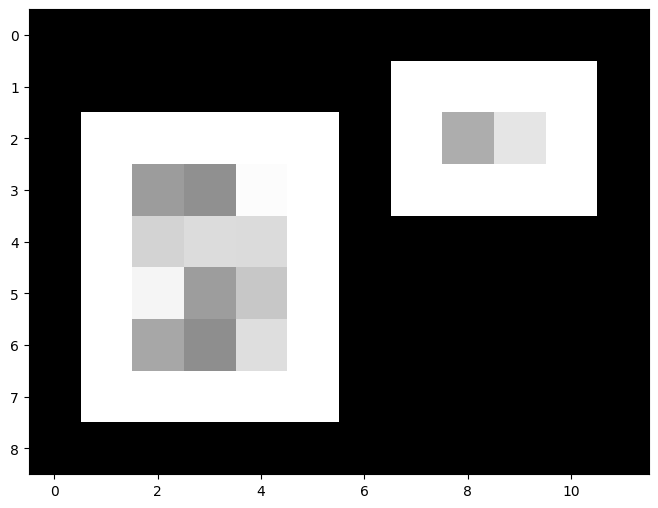

In [16]:
# plot result

frame_plot = deepcopy(frame_2d)

num_cell = boxDetect.num_cell
batch_size = frame.shape[0]

for b in range(batch_size):
    for i in range(num_cell):
        for j in range(num_cell):
            result_ij = result[:, :, i, j].detach().cpu().numpy()
            
    
            if result_ij[b][0] > 0.5:
                #print(result[:, :, i, j], end=" ")
                print("class probability: ", result_ij[b][0], end=" ")
                print(", object center (y, x): ", result_ij[b][1:3], end = " ")
                print(", object height: ", result_ij[b][3],  ", width: ", result_ij[b][4])
                
                top_left = np.zeros(2)
                top_left[0] = result_ij[b][2] - result_ij[b][4]/2
                top_left[1] = result_ij[b][1] - result_ij[b][3]/2

                bot_right = np.zeros(2)
                bot_right[0] = result_ij[b][2] + result_ij[b][4]/2
                bot_right[1] = result_ij[b][1] + result_ij[b][3]/2

                top_left = top_left.astype(int)
                bot_right = bot_right.astype(int)

                top_left_pos = top_left > 0
                top_left_pos = top_left_pos.sum()

                bot_right_pos = bot_right > 0
                bot_right_pos = bot_right_pos.sum()

                # plot if all positive
                if top_left_pos == top_left.shape[0] and bot_right_pos == bot_right.shape[0]:
                    cv2.rectangle(frame_plot, top_left, bot_right, 255, 1)
                
        print()

plt.imshow(frame_plot, cmap='gray', vmin=0, vmax=255)
plt.show()

## a larger frame

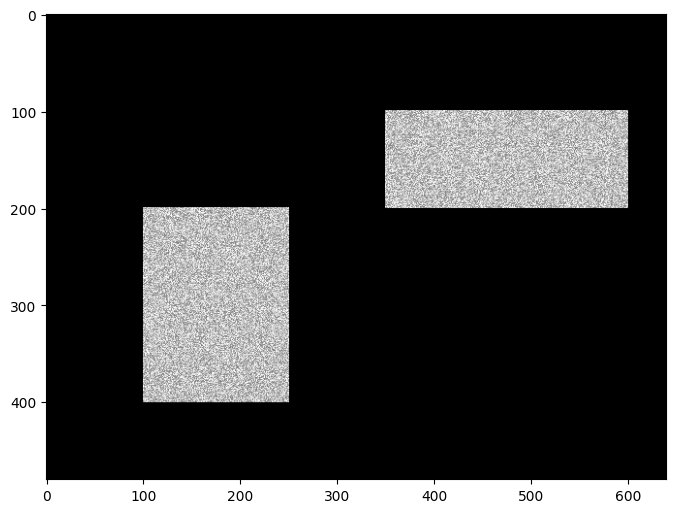

In [17]:
# small frame example
width, height = 640, 480
frame_full = np.random.rand(height, width) * 128 + 128
frame_full = frame_full.astype(np.uint8)

#print(frame_full.shape)

#plt.imshow(frame_full, cmap='gray', vmin=0, vmax=255)
#plt.show()

mask = np.zeros([height, width], dtype="uint8")
cv2.rectangle(mask, (100, 200), (250, 400), 255, -1)
cv2.rectangle(mask, (350, 100), (600, 200), 255, -1)


frame_2d = cv2.bitwise_and(frame_full, frame_full, mask=mask)

plt.imshow(frame_2d, cmap='gray', vmin=0, vmax=255)
plt.show()

In [18]:
frame = np.expand_dims(frame_2d, axis=(0, 1) )

In [19]:
result = boxDetect(frame)
result, result.shape

location: 
[[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]]]



 [[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]]]]
cumulative: 
[[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]]]



 [[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]]]]
inverse cumulative: 
[[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]]]



 [[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 

(tensor([[[[ 4.3782e-01,  4.3782e-01,  4.3782e-01,  4.3782e-01,  4.3782e-01,
             4.3782e-01,  4.3782e-01],
           [ 4.3782e-01,  4.3782e-01,  4.3782e-01,  4.5297e-01,  5.3700e-01,
             5.3668e-01,  4.9555e-01],
           [ 4.3782e-01,  4.4770e-01,  4.4603e-01,  4.6543e-01,  6.1572e-01,
             6.1569e-01,  5.4246e-01],
           [ 4.3782e-01,  6.0498e-01,  5.7931e-01,  4.3782e-01,  4.3782e-01,
             4.3782e-01,  4.3782e-01],
           [ 4.3782e-01,  6.0606e-01,  5.7975e-01,  4.3782e-01,  4.3782e-01,
             4.3782e-01,  4.3782e-01],
           [ 4.3782e-01,  5.8805e-01,  5.6421e-01,  4.3782e-01,  4.3782e-01,
             4.3782e-01,  4.3782e-01],
           [ 4.3782e-01,  4.3782e-01,  4.3782e-01,  4.3782e-01,  4.3782e-01,
             4.3782e-01,  4.3782e-01]],
 
          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.5000e+02,  1.50

### plot detected, with white box surrounding object


class probability:  0.53700036 , object center (y, x):  [150. 475.] , object height:  100.0 , width:  250.0
class probability:  0.5366754 , object center (y, x):  [150. 475.] , object height:  100.0 , width:  250.0

class probability:  0.61572075 , object center (y, x):  [150. 475.] , object height:  100.0 , width:  250.0
class probability:  0.6156866 , object center (y, x):  [150. 475.] , object height:  100.0 , width:  250.0
class probability:  0.54246384 , object center (y, x):  [150. 475.] , object height:  100.0 , width:  250.0

class probability:  0.6049785 , object center (y, x):  [300. 175.] , object height:  200.0 , width:  150.0
class probability:  0.57931405 , object center (y, x):  [300. 175.] , object height:  200.0 , width:  150.0

class probability:  0.6060561 , object center (y, x):  [300. 175.] , object height:  200.0 , width:  150.0
class probability:  0.5797496 , object center (y, x):  [300. 175.] , object height:  200.0 , width:  150.0

class probability:  0.588050

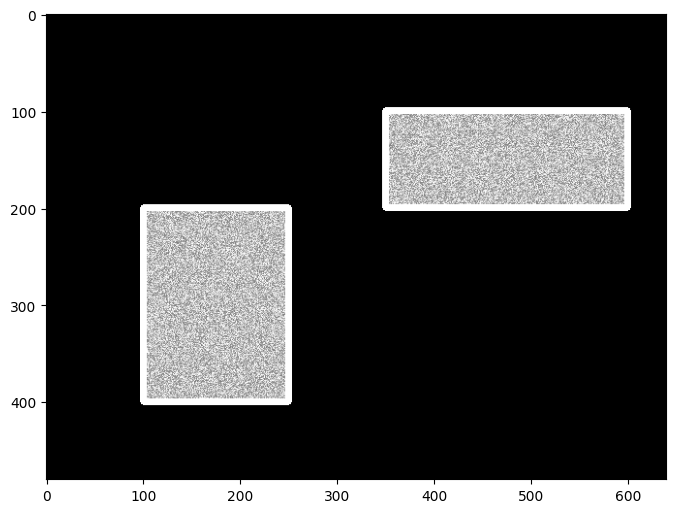

In [20]:
# plot result

frame_plot = deepcopy(frame_2d)

num_cell = boxDetect.num_cell
batch_size = frame.shape[0]

for b in range(batch_size):
    for i in range(num_cell):
        for j in range(num_cell):
            result_ij = result[:, :, i, j].detach().cpu().numpy()
            
    
            if result_ij[b][0] > 0.5:
                #print(result[:, :, i, j], end=" ")
                print("class probability: ", result_ij[b][0], end=" ")
                print(", object center (y, x): ", result_ij[b][1:3], end = " ")
                print(", object height: ", result_ij[b][3],  ", width: ", result_ij[b][4])
                
                top_left = np.zeros(2)
                top_left[0] = result_ij[b][2] - result_ij[b][4]/2
                top_left[1] = result_ij[b][1] - result_ij[b][3]/2

                bot_right = np.zeros(2)
                bot_right[0] = result_ij[b][2] + result_ij[b][4]/2
                bot_right[1] = result_ij[b][1] + result_ij[b][3]/2

                top_left = top_left.astype(int)
                bot_right = bot_right.astype(int)

                top_left_pos = top_left > 0
                top_left_pos = top_left_pos.sum()

                bot_right_pos = bot_right > 0
                bot_right_pos = bot_right_pos.sum()

                # plot if all positive
                #########################################################################
                # carefully check cv2.rectangle thickness, here is 5
                #########################################################################
                if top_left_pos == top_left.shape[0] and bot_right_pos == bot_right.shape[0]:
                    cv2.rectangle(frame_plot, top_left, bot_right, 255, 5)
                
        print()

plt.imshow(frame_plot, cmap='gray', vmin=0, vmax=255)
plt.show()